# Inference using the SynFerm models

In principle, this notebook works the same as `inference.ipynb`, but we keep it separate for reproducibility of the validation plate predictions


In [48]:
import pathlib
import statistics
import sys
sys.path.append(str(pathlib.Path("__file__").absolute().parents[1]))

import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader

from src.util.definitions import TRAINED_MODEL_DIR, LOG_DIR, DATA_ROOT
from src.model.classifier import load_trained_model
from src.data.dataloader import SynFermDataset, collate_fn
from reaction_generator import SFReactionGenerator

In [49]:
def import_smiles(
    raw_dir: pathlib.Path, filename: str, valid_idx_file: pathlib.Path = None
):
    """Import smiles from a csv file and filter by indices supplied in a second csv file"""
    smiles_df = pd.read_csv(raw_dir / filename)
    if valid_idx_file is None:
        return smiles_df
    else:
        indices_arr = pd.read_csv(valid_idx_file)["index"].to_numpy()
        return smiles_df.loc[indices_arr]

In [50]:
# paths to the best models
model_0D_name = "2023-11-29-145809_246697_fold0"
model_0D = TRAINED_MODEL_DIR / model_0D_name / "last-epoch42-val_loss0.20.ckpt"  # FFN
# path to the OneHotEncoder state for model_0D
ohe_state_dict = LOG_DIR / "OHE_state_dict_YCYzhoYPdFmypyNV.json"
assert model_0D.is_file()
assert ohe_state_dict.is_file()

To use the notebook on your products, change `raw_dir` to the directory that your CSV file containing SMILES is in. Then change `filename_base` to the filename of your csv file without the `.csv` suffix. If you do not want to use all the SMILES in your file (e.g. because some are not valid SLAP products), suppy a `valid_idx_file`. You can set the value to `None` if you want to use all SMILES.

In [51]:
# Import product SMILES
raw_dir = DATA_ROOT
filename = "validation-plate_candidates.csv"
valid_idx_file = None
df = import_smiles(raw_dir, filename, valid_idx_file=valid_idx_file)
df.head()

,vl_id,long_name,product_A_smiles
0,224342,Ph031 + Spiro013 + TerTH016,COc1ccccc1-c1nnc(CC2(NC(=O)c3ccc(C4=NCCO4)cc3)...
1,224328,Ph031 + Spiro013 + TerABT022,CCOc1ccc2nc(CC3(NC(=O)c4ccc(C5=NCCO5)cc4)CN(C(...
2,224321,Ph031 + Spiro013 + TerABT012,O=C(NC1(Cc2nc3cc(Cl)ccc3s2)CN(C(=O)O[C@H]2CCOC...
3,224341,Ph031 + Spiro013 + TerTH015,O=C(NC1(Cc2nnc(-c3cc(Cl)cc(Cl)c3)s2)CN(C(=O)O[...
4,224351,Ph031 + Spiro013 + TerTH027,O=C(NC1(Cc2nnc(-c3ccc4[nH]nnc4c3)s2)CN(C(=O)O[...


In [52]:
# check if all these were actually in the training data for the model we use
dfs = [pd.read_csv(TRAINED_MODEL_DIR / model_0D_name / f"train_{bb}.csv") for bb in ["initiators", "monomers", "terminators"]]
used_building_blocks = pd.concat(dfs)
used_building_blocks    


,long,smiles
0,2-Pyr003,O=C(c1cccc(Cl)n1)[B-](F)(F)F
1,2-Pyr006,O=C(c1ccc(Br)cn1)[B-](F)(F)F
2,2-Pyr007,O=C(c1cccc(F)n1)[B-](F)(F)F
3,2-Pyr008,O=C(c1ccc(F)cn1)[B-](F)(F)F
4,2-Pyr009,COc1ccc(C(=O)[B-](F)(F)F)nc1
...,...,...
36,TerTH023,NNC(=S)c1cccc2[nH]ncc12
37,TerTH025,NNC(=S)c1c[nH]cn1
38,TerTH026,NNC(=S)c1cn[nH]c1
39,TerTH027,NNC(=S)c1ccc2[nH]nnc2c1


In [81]:
"Ph011" in used_building_blocks.values

False

In [53]:
# anything that shows up here will not be recognized by the one-hot encoder
df.loc[~df["long_name"].str.split("+").apply(lambda x: all([i.strip() in used_building_blocks["long"].values for i in x]))]

,vl_id,long_name,product_A_smiles


In [54]:
# first we need to generate the reactionSMILES. This will take a moment
gen = SFReactionGenerator()
df["reaction_smiles_atom_mapped"] = df["product_A_smiles"].apply(lambda x: gen.get_reaction_smiles(x))
df.head()

,vl_id,long_name,product_A_smiles,reaction_smiles_atom_mapped
0,224342,Ph031 + Spiro013 + TerTH016,COc1ccccc1-c1nnc(CC2(NC(=O)c3ccc(C4=NCCO4)cc3)...,F[B-](F)(F)[C:1](=[O:2])[c:11]1[cH:12][cH:14][...
1,224328,Ph031 + Spiro013 + TerABT022,CCOc1ccc2nc(CC3(NC(=O)c4ccc(C5=NCCO5)cc4)CN(C(...,F[B-](F)(F)[C:1](=[O:2])[c:15]1[cH:16][cH:18][...
2,224321,Ph031 + Spiro013 + TerABT012,O=C(NC1(Cc2nc3cc(Cl)ccc3s2)CN(C(=O)O[C@H]2CCOC...,F[B-](F)(F)[C:1](=[O:2])[c:15]1[cH:16][cH:18][...
3,224341,Ph031 + Spiro013 + TerTH015,O=C(NC1(Cc2nnc(-c3cc(Cl)cc(Cl)c3)s2)CN(C(=O)O[...,F[B-](F)(F)[C:1](=[O:2])[c:11]1[cH:12][cH:14][...
4,224351,Ph031 + Spiro013 + TerTH027,O=C(NC1(Cc2nnc(-c3ccc4[nH]nnc4c3)s2)CN(C(=O)O[...,F[B-](F)(F)[C:1](=[O:2])[c:11]1[cH:12][cH:14][...


In [55]:
# save this
df.to_csv(DATA_ROOT / "validation-plate_candidates_reactionSMILES.csv")

In [56]:
# instantiate data set. This will also take a moment
data = SynFermDataset(
    name="validation-plate_candidates_reactionSMILES.csv",
    raw_dir=DATA_ROOT,
    reaction=True,
    global_features=["OHE", ],
    global_featurizer_state_dict_path=ohe_state_dict,
    graph_type="bond_edges",
    featurizers="custom",
    smiles_columns=["reaction_smiles_atom_mapped"],
    label_columns=None,
    task="multilabel"
)

Done saving data into cached files.


In [57]:
# run the predictions

# load the trained model 
model_0D = load_trained_model("FFN", model_0D)
model_0D.eval()
trainer = pl.Trainer(accelerator="gpu", logger=False, max_epochs=-1)
# prepare data
dl = DataLoader(data, collate_fn=collate_fn, num_workers=0)
# predict
probabilities_0D = torch.sigmoid(torch.concat(trainer.predict(model_0D, dl)))
    

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/julian/miniconda3/envs/synferm-predictions/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [58]:
probabilities_0D

tensor([[1.0000, 0.9999, 0.7957],
        [0.9769, 0.0433, 0.0028],
        [0.5372, 0.0518, 0.0014],
        ...,
        [0.9998, 0.9650, 0.2429],
        [0.9584, 0.4763, 0.0080],
        [1.0000, 0.9957, 0.7943]])

In [59]:
# load decision thresholds
with open(LOG_DIR / "thresholds" / f"{model_0D_name}.txt", "r") as f:
    thresholds = [float(i) for i in f.readlines()]
print(thresholds)

[0.56, 0.47, 0.49]


In [60]:
# apply the thresholds
preds = torch.stack([torch.where(probabilities_0D[:, i] > thresholds[i], 1, 0) for i in range(3)], dim=1)

In [61]:
# combine with data
df[["prob_A", "prob_B", "prob_C"]] = probabilities_0D
df[["pred_A", "pred_B", "pred_C"]] = preds 

In [70]:
df.head()

,vl_id,long_name,product_A_smiles,reaction_smiles_atom_mapped,prob_A,prob_B,prob_C,pred_A,pred_B,pred_C
0,224342,Ph031 + Spiro013 + TerTH016,COc1ccccc1-c1nnc(CC2(NC(=O)c3ccc(C4=NCCO4)cc3)...,F[B-](F)(F)[C:1](=[O:2])[c:11]1[cH:12][cH:14][...,0.999996,0.999853,0.795703,1,1,1
1,224328,Ph031 + Spiro013 + TerABT022,CCOc1ccc2nc(CC3(NC(=O)c4ccc(C5=NCCO5)cc4)CN(C(...,F[B-](F)(F)[C:1](=[O:2])[c:15]1[cH:16][cH:18][...,0.976899,0.043333,0.002816,1,0,0
2,224321,Ph031 + Spiro013 + TerABT012,O=C(NC1(Cc2nc3cc(Cl)ccc3s2)CN(C(=O)O[C@H]2CCOC...,F[B-](F)(F)[C:1](=[O:2])[c:15]1[cH:16][cH:18][...,0.537250,0.051775,0.001379,0,0,0
3,224341,Ph031 + Spiro013 + TerTH015,O=C(NC1(Cc2nnc(-c3cc(Cl)cc(Cl)c3)s2)CN(C(=O)O[...,F[B-](F)(F)[C:1](=[O:2])[c:11]1[cH:12][cH:14][...,0.999267,0.999506,0.103978,1,1,0
4,224351,Ph031 + Spiro013 + TerTH027,O=C(NC1(Cc2nnc(-c3ccc4[nH]nnc4c3)s2)CN(C(=O)O[...,F[B-](F)(F)[C:1](=[O:2])[c:11]1[cH:12][cH:14][...,0.999868,0.999875,0.359415,1,1,0


In [64]:
# summarize our predictions
df["pred_A"].value_counts()

pred_A
1    900
0    292
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

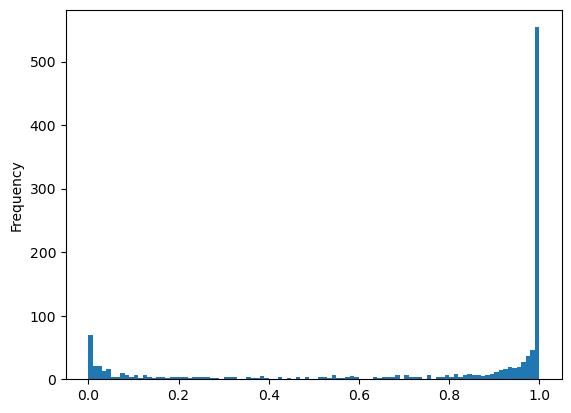

In [69]:
df["prob_A"].plot.hist(bins=100)

In [74]:
(df["pred_A"] == 1)

0        True
1        True
2       False
3        True
4        True
        ...  
1187     True
1188     True
1189     True
1190     True
1191     True
Name: pred_A, Length: 1192, dtype: bool

In [75]:
# write df to output file
df.to_csv(DATA_ROOT / f"validation-plate_candidates_predictions.csv", index=False)